# Imports

In [1]:
import gym
import os
import numpy as np
from random import randint
from sklearn.utils import shuffle
import math
import torch
import torch.nn.functional as F
import torch.autograd as autograd 
from torch import nn
from torch import optim
import random
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm as tqdm
from statistics import mean, stdev

env = gym.make('MountainCarContinuous-v0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce RTX 2080 SUPER'

In [2]:
print("Action space:" , env.action_space) 
print("Observation matrix:", env.observation_space)
print("Observation min:",env.observation_space.low)
print("Observation max:", env.observation_space.high)

Action space: Box(-1.0, 1.0, (1,), float32)
Observation matrix: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Observation min: [-1.2  -0.07]
Observation max: [0.6  0.07]


# Functions

In [3]:
class ReLU(nn.Module):
    #Regular Relu except it subtracts by mean
    
    def forward(self, inp): return (inp.clamp_min(0.) - inp.clamp_min(0.).mean())

class Actor(nn.Module):
    def __init__(self, layers, goal_size = 0):
        
        super(Actor, self).__init__()

        modules = []
        modules.append(nn.Linear(layers[0] + goal_size, layers[1])) #+1 from action_size and +1 from goal_dim
        
        for i in range(1,len(layers)-1):
            modules.append(ReLU())
            modules.append(nn.Linear(layers[i], layers[i+1]))
            
        self.model = nn.Sequential(*modules)
        self.reset_parameters()
        
    def forward(self,state, goal):        
        x = torch.cat([state,goal], dim = -1)    
        return self.model(x.float()) #tanh to bring to -1, 1
    def reset_parameters(self):
        for p in self.model.parameters():
            kaiming = 2/np.sqrt(p.data.size()[0])
            nn.init.uniform_(p.data, -kaiming, kaiming)

class Critic(nn.Module):
    def __init__(self, layers, action_size = 1, goal_size = 0):

        super(Critic, self).__init__()

        modules = []
        modules.append(nn.Linear(layers[0]+action_size + goal_size, layers[1])) #+1 from action_size and +1 from goal_dim
        
        for i in range(1,len(layers)-1):
            modules.append(ReLU())
            modules.append(nn.Linear(layers[i], layers[i+1]))
            
        self.model = nn.Sequential(*modules)
        self.reset_parameters()
        
    def forward(self, state, action, goal = None):
        if goal is not None: x = torch.cat((state,action,goal), dim = 1)
        else: x = torch.cat((state, action), dim = 1)
        return self.model(x)
    def reset_parameters(self):
        for p in self.model.parameters():
            kaiming = 2/np.sqrt(p.data.size()[0])
            nn.init.uniform_(p.data, -kaiming, kaiming)    
    
#Class is useful so that I remember the order of appends using shift+tab
class Memory():
    def __init__(self, maxMemory):
        #Deque is a fifo list with a max length
        self.memory = deque(maxlen = maxMemory)
        
    #Passes in Bellman equation parameters
    def update(self, goal, state, action, reward, next_state, done):
        self.memory.append((goal, state, action, reward, next_state, done))
    
    #Takes a sample of size batch_size from memory
    def sample(self, batch_size):
        #Zip into tuples all states, then all actions, then all rewards, etc
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    
    def __repr__(self):
        return str(self.memory)

    
    
def epsilon_decay(step, eps_max, eps_min, eps_decay):
    return eps_min + (eps_max - eps_min) * math.exp(-1. * step * eps_decay)

def update_model(model,target_model,model_opt, critic,target_critic, critic_opt,memory,discount,batch_size):

    #Take a sample from memory with batch size
    goals, states, actions, rewards, next_states, dones = memory.sample(batch_size)

    goals = toTorch(goals)
    states = toTorch(states)
    actions = toTorch(actions)
    rewards = toTorch(rewards).unsqueeze(1) #[bs,1]
    next_states = toTorch(next_states)
    dones = toTorch(dones).unsqueeze(1) #[bs,1]
    
    next_actions = target_model(next_states, goals)
    next_Qs = target_critic(next_states, next_actions, goals)

    bellman = rewards + (1-dones) * discount * next_Qs
    expected_Qs = critic(states, actions, goals)
    
    critic_loss = loss_func(bellman,expected_Qs) 

    #Critic Gradient 
    critic_opt.zero_grad()    
    critic_loss.backward()
    critic_opt.step()

    actions_pred = model(states, goals)
    actor_loss = -critic(states, actions_pred, goals).mean()
    
    # Minimize the loss
    model_opt.zero_grad()
    actor_loss.backward()
    model_opt.step()


def plot(rewards, text):
    clear_output(True)
    fig = plt.figure(figsize=(20,5))
    plt.xlabel(text, ha="center")
    plt.title(f"Rewards, Batch # {len(rewards)}")
    plt.plot(rewards)
    plt.show()
    return fig

def toTorch(x):
    return torch.tensor(x).float().to(device)

def run(layers, batch_size, discount, eps_max, eps_min, eps_decay, update_freq, lr, memory_size, loss_func, noise_scale):

    goal = np.array([env.goal_position])
    low = env.action_space.low[0] 
    high = env.action_space.high[0]
    noise = noise_scale


    model = Actor(layers, goal_size = len(goal)).cuda()
    target_model = Actor(layers, goal_size = len(goal)).cuda()

    critic = Critic(layers, action_size = 1, goal_size = len(goal)).cuda()
    target_critic = Critic(layers, action_size = 1, goal_size = len(goal)).cuda()

    model_opt = optim.Adam(model.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    rewards = []
    memory = Memory(int(memory_size))

    max_reward = 0
    best_episode = 0
    iter = 0

    name = (f"      Layers: {layers}"
            f"      Loss function: {loss_func.__name__}"
            f"      Batch size: {batch_size}"
            f"      Discount: {discount}"
            f"      Epsilon: {eps_max} to {eps_min} decay: {eps_decay}"
            f"      Learning rate: {lr}"
            f"      Update freq: {update_freq}"
            f"      Memory size: {memory_size}")

    for episode in range(1,num_episodes+1):

        state = env.reset()
        episode_rewards = 0
        done = False


        while not done: #Run until poll falls or env time ends

            #Lets you watch, but trains so much faster if you don't
            #env.render()

            #Calculate Q Value
            Q = model(toTorch(state),toTorch(goal))

            epsilon = epsilon_decay(iter, eps_max, eps_min, eps_decay)

            #Do we do take a random action?
            if random.random() > epsilon:
                action = [torch.clamp(Q + noise, low, high).item()] #Clamp makes sure it's within acceptable range
            else:
                action = [np.random.uniform(low, high)] #Random action

            #Take step and update memory
            next_state, reward, done, info = env.step(action) 
            #if reward < 0: reward = 0
            memory.update(goal, state, action, reward, next_state, done)
            memory.update([state[0]],state, action, 100, next_state, True) #HER implementation

            #Updates the model if you can take a proper batch
            if len(memory) > batch_size:
                update_model(model,target_model,model_opt, critic,target_critic, critic_opt,memory,discount,batch_size) #SGD w/ return loss

            #Update target model every update_freq steps:
            if iter%update_freq == 0: 
                target_model.load_state_dict(model.state_dict())
                target_critic.load_state_dict(critic.state_dict())

            #Updates
            state = next_state
            episode_rewards += reward
            iter += 1


        rewards.append(episode_rewards)    
        if episode_rewards > max_reward:
            max_reward = episode_rewards
            best_episode = episode

        plot(rewards, name)
        print(epsilon, max_reward)

        #End condition
        if len(rewards)>100:
            average = mean(rewards[-100:])
            print(average)
            if average > 0:
                env.close()
                print(f"Finished in {episode} episodes!")
                return episode

# Set up

In [4]:
num_episodes = 500

m = env.observation_space.shape[0]
n = 1

layers = [m,64,64,64,n]

loss_func = F.mse_loss

batch_size = 128
memory_size = 1e5
discount = 0.99
eps_max = 1
eps_min = 1e-4
eps_decay = 5e-5
update_freq = 50 #How frequently target network gets updated 
lr = 1e-3
noise= 0.01 #Random noise is added to each move


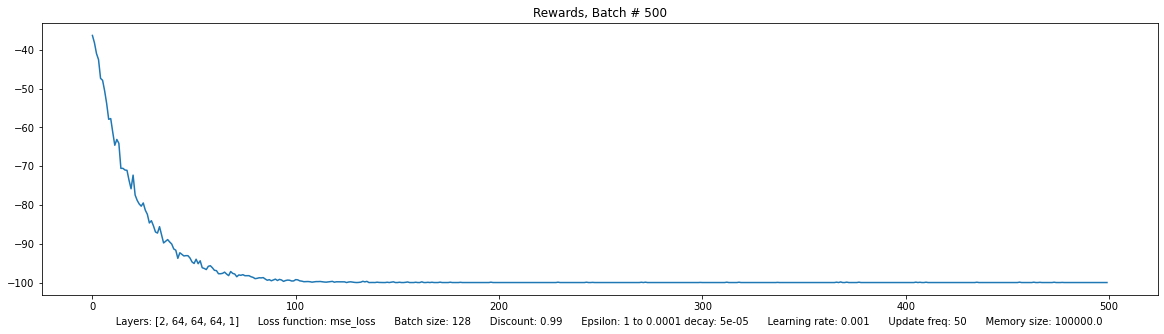

0.00010000001423880681 0
-99.89244479377939


In [5]:
results = run(layers,  batch_size, discount, eps_max, eps_min, eps_decay, update_freq, lr, memory_size, loss_func, noise)